# Sample code for stacking

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:20:01.201946. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [16]:
## Read the train and test dataset and check the top few lines ##
train_df = pd.read_csv("../input/train_v2.csv")
test_df = pd.read_csv("../input/test_v2.csv")
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

('Number of rows in train dataset : ', 19579)
('Number of rows in test dataset : ', 8392)


/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:20:01.577745. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [17]:
train_df.head()

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,...,svd_char_10,svd_char_11,svd_char_12,svd_char_13,svd_char_14,svd_char_15,svd_char_16,svd_char_17,svd_char_18,svd_char_19
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,231,19,7,2,3,...,-0.014060,0.024332,0.021053,-0.011783,0.014391,-0.008009,0.013331,-0.050801,0.006386,0.017673
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,71,8,1,0,1,...,-0.005025,0.058803,0.053368,-0.025234,-0.054745,0.004292,0.020517,-0.021551,-0.043966,-0.062726
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,200,16,5,0,1,...,0.033147,-0.041294,0.006699,0.010584,-0.021652,-0.012883,-0.048039,0.006840,-0.007042,0.000872
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,206,13,4,0,4,...,0.012433,0.013249,0.045197,-0.016095,-0.023079,-0.017996,-0.024845,0.009133,0.029233,0.016250
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,174,11,4,0,2,...,-0.044100,0.099443,-0.007989,-0.058220,0.023924,0.012136,-0.002706,-0.013356,0.020759,0.024944


/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:20:02.032955. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [18]:
## Prepare the data for modeling ###
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values
print train_df.shape, test_df.shape

(19579, 51) (8392, 50)


/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:20:02.305726. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Read all the prediction files and use them for stacking

In [20]:
for file_name in ["nb_tfidf.csv", "nb_cvec.csv", "nb_char_tfidf.csv", "nb_char_cvec.csv"]:
    fname = file_name.replace(".csv","")
    train_df2 = pd.read_csv("./meta_models/val/"+file_name)
    train_df2.columns = ["id"] + [fname+"_"+name for name in train_df2.columns if name not in ["id"]]
    test_df2 = pd.read_csv("./meta_models/test/"+file_name)
    test_df2.columns = ["id"] + [fname+"_"+name for name in test_df2.columns if name not in ["id"]]
    train_df = pd.merge(train_df, train_df2, on="id")
    test_df = pd.merge(test_df, test_df2, on="id")
    print train_df.shape, test_df.shape

(19579, 54) (8392, 53)
(19579, 57) (8392, 56)
(19579, 60) (8392, 59)
(19579, 63) (8392, 62)


/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:20:44.720675. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [21]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:20:51.942544. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [23]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    #break
print("cv scores : ", np.mean(cv_scores))


[0]	train-mlogloss:1.00336	test-mlogloss:1.00349
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.408756	test-mlogloss:0.414988
[40]	train-mlogloss:0.339712	test-mlogloss:0.353537
[60]	train-mlogloss:0.315529	test-mlogloss:0.336463
[80]	train-mlogloss:0.298395	test-mlogloss:0.327361
[100]	train-mlogloss:0.285165	test-mlogloss:0.321628
[120]	train-mlogloss:0.273538	test-mlogloss:0.317521
[140]	train-mlogloss:0.263974	test-mlogloss:0.314607
[160]	train-mlogloss:0.2554	test-mlogloss:0.312871
[180]	train-mlogloss:0.247543	test-mlogloss:0.311416
[200]	train-mlogloss:0.24034	test-mlogloss:0.310575
[220]	train-mlogloss:0.233351	test-mlogloss:0.309636
[240]	train-mlogloss:0.226726	test-mlogloss:0.309377
[260]	train-mlogloss:0.219944	test-mlogloss:0.308463
[280]	train-mlogloss:0.214049	test-mlogloss:0.307917
[300]	train-mlogloss:0.207903	test-mlogloss:0.307774
[320]	train-

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:21:23.654749. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


CV score is 0.31140 and is much better than our individual model cv of 0.4509

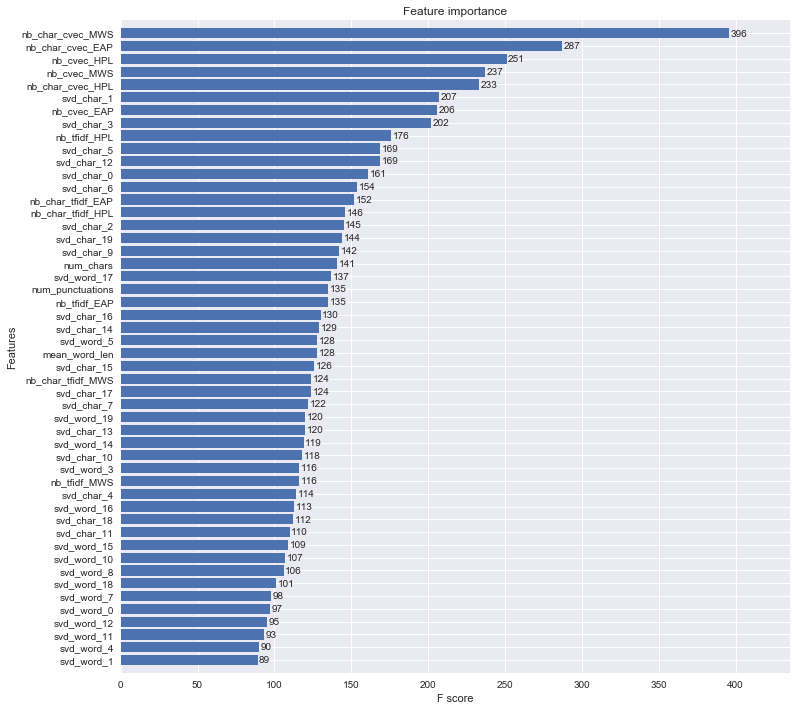

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:23:59.793367. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [24]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()